<a href="https://colab.research.google.com/github/dcpatton/keras_tuner/blob/master/keras_tuning_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import random

seed = 52
tf.random.set_seed(seed)
random.seed(seed)

print('TensorFlow version = ' + tf.__version__)

accuracies = [] # for metric tracking

TensorFlow version = 2.3.0


In [2]:
!pip install keras-tuner -q
import kerastuner as kt
print('Keras Tuner version = ' + kt.__version__)

     |████████████████████████████████| 61kB 1.9MB/s 
Keras Tuner version = 1.0.1


# Get the data
As before, we will use CIFAR10.

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 11s 0us/step


Previously we used the RandomTuner. How about the BayesianOptimization tuner?


In [4]:
def build_hypermodel(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.Dense(units=hp.Int('u_1', min_value=16, max_value=256, step=16), 
                                  activation=hp.Choice(name='a_1', values=['relu','tanh','elu','selu','swish'])))
  model.add(tf.keras.layers.Dense(units=hp.Int('u_2', min_value=16, max_value=256, step=16), 
                                  activation=hp.Choice(name='a_2', values=['relu','tanh','elu','selu','swish'])))
  model.add(tf.keras.layers.Dense(units=hp.Int('u_3', min_value=16, max_value=256, step=16), 
                                  activation=hp.Choice(name='a_3', values=['relu','tanh','elu','selu','swish'])))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
  
  return model

In [5]:
tuner = kt.BayesianOptimization(hypermodel=build_hypermodel,
                        objective='val_loss',
                        max_trials=25,
                        num_initial_points=2,
                        directory='test_dir',
                        project_name='a',
                        seed=seed
                        )

tuner.search_space_summary()

In [6]:
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [7]:
BATCH_SIZE = 128

In [8]:
es = tf.keras.callbacks.EarlyStopping(patience=10)
tuner.search(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
             validation_data=(test_images, test_labels), 
             verbose=0, callbacks=[es, ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [9]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [10]:
print(f"""
The hyperparameter search is complete. The optimal activation in the first densely-connected
layer is {best_hps.get('a_1')}. The optimal activation in the second densely-connected
layer is {best_hps.get('a_2')}. The optimal activation in the third densely-connected
layer is {best_hps.get('a_3')}.
""")


The hyperparameter search is complete. The optimal activation in the first densely-connected
layer is relu. The optimal activation in the second densely-connected
layer is swish. The optimal activation in the third densely-connected
layer is relu.



In [11]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               786688    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170       
Total params: 856,762
Trainable params: 856,762
Non-trainable params: 0
_________________________________________________________________


The BayesianOptimization tuner chose 256, 256, and 16 hidden units for the Dense layers.

In [12]:
filepath = 'model.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=0)

Epoch 00089: early stopping


In [13]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 1.9780422449111938
Accuracy = 0.4799000024795532


Previously the best result achieved with the RandomTuner was 

```
Loss = 1.9605963230133057
Accuracy = 0.4959000051021576
```

So the results are nearly identical.

# Tune the DNN depth and width

In [14]:
def build_hypermodel(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
  for i in range(hp.Int('num_layers', 2, 4)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 64, 512, 64),
                               activation='elu'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
  
  return model

In [15]:
tuner = kt.BayesianOptimization(hypermodel=build_hypermodel,
                        objective='val_loss',
                        max_trials=25,
                        num_initial_points=2,
                        directory='test_dir',
                        project_name='b',
                        seed=seed
                        )

tuner.search_space_summary()

In [16]:
es = tf.keras.callbacks.EarlyStopping(patience=10)
tuner.search(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
             validation_data=(test_images, test_labels), 
             verbose=0, callbacks=[es, ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [17]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                196672    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 215,882
Trainable params: 215,882
Non-trainable params: 0
_________________________________________________________________


In [18]:
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=0)

Epoch 00035: early stopping


In [19]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 1.9776431322097778
Accuracy = 0.4814000129699707


This is a slight improvement.

# Tune Depth Only

Set hidden units at 128 and allow tuner to choose best number_of_layers.

In [20]:
def build_hypermodel(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
  for i in range(hp.Int('num_layers', 2, 20)):
        model.add(tf.keras.layers.Dense(128, activation='elu'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
  
  return model

In [21]:
tuner = kt.BayesianOptimization(hypermodel=build_hypermodel,
                        objective='val_loss',
                        max_trials=25,
                        num_initial_points=2,
                        directory='test_dir',
                        project_name='d',
                        seed=seed
                        )

In [22]:
es = tf.keras.callbacks.EarlyStopping(patience=10)
tuner.search(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
             validation_data=(test_images, test_labels), 
             verbose=0, callbacks=[es, ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [23]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 411,146
Trainable params: 411,146
Non-trainable params: 0
_________________________________________________________________


In [24]:
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=0)

Epoch 00086: early stopping


In [25]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 1.955668330192566
Accuracy = 0.5008000135421753


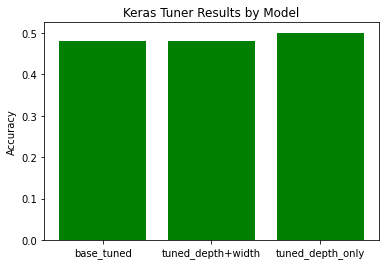

In [26]:
import matplotlib.pyplot as plt

labels = ['base_tuned', 'tuned_depth+width', 'tuned_depth_only']

x_pos = [i for i, _ in enumerate(labels)]

plt.bar(x_pos, accuracies, color='green')
plt.ylabel("Accuracy")
plt.title("Keras Tuner Results by Model")

plt.xticks(x_pos, labels)

plt.show()